In [26]:
import comet_ml
from comet_ml import API
from comet_ml import Experiment

experiment = Experiment('HU8yNOX96Ang8huavKsvrTbiK', project_name="diff_sim_ffjord", workspace="schattengenie")

COMET INFO: ----------------------------
COMET INFO: Comet.ml Experiment Summary:
COMET INFO:   Data:
COMET INFO:     url: https://www.comet.ml/schattengenie/diff-sim-ffjord/84b2ec246ea94a798c6f64c029d7a9d9
COMET INFO:   Metrics:
COMET INFO:                          loss: 7.254089832305908
COMET INFO:         sys.gpu.0.free_memory: 9607249920
COMET INFO:     sys.gpu.0.gpu_utilization: 0
COMET INFO:        sys.gpu.0.total_memory: 11996954624
COMET INFO:         sys.gpu.0.used_memory: 2389704704
COMET INFO:         sys.gpu.1.free_memory: 11432820736
COMET INFO:     sys.gpu.1.gpu_utilization: 0
COMET INFO:        sys.gpu.1.total_memory: 11996954624
COMET INFO:         sys.gpu.1.used_memory: 564133888
COMET INFO:         sys.gpu.2.free_memory: 11985420288
COMET INFO:     sys.gpu.2.gpu_utilization: 0
COMET INFO:        sys.gpu.2.total_memory: 11996954624
COMET INFO:         sys.gpu.2.used_memory: 11534336
COMET INFO:         sys.gpu.3.free_memory: 11985420288
COMET INFO:     sys.gpu.3.gpu_u

In [27]:
from model import YModel, OptLoss

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch

import numpy as np
from tqdm import trange, tqdm_notebook

import matplotlib.pyplot as plt
import seaborn as sns

## Recovering conditional density with FFJORD

# All needed imports

In [28]:
device = torch.device('cuda:1')

In [29]:
import sys
import torch
import torch.optim as optim
from IPython.display import clear_output

sys.path.append('./ffjord/')
import ffjord.lib.utils as utils
from ffjord.lib.visualize_flow import visualize_transform
import ffjord.lib.layers.odefunc as odefunc
from ffjord.train_misc import standard_normal_logprob
from ffjord.train_misc import count_nfe, count_parameters, count_total_time
from ffjord.train_misc import add_spectral_norm, spectral_norm_power_iteration
from ffjord.train_misc import create_regularization_fns, get_regularization, append_regularization_to_log
from ffjord.train_misc import build_model_tabular
import lib.layers as layers

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [31]:
SOLVERS = ["dopri5", "bdf", "rk4", "midpoint", 'adams', 'explicit_adams', 'fixed_adams']

print(odefunc.NONLINEARITIES)

{'tanh': Tanh(), 'relu': ReLU(), 'softplus': Softplus(beta=1, threshold=20), 'elu': ELU(alpha=1.0), 'swish': Swish(), 'square': Lambda(), 'identity': Lambda()}


In [32]:
def set_cnf_options(model, solver, rademacher, residual, atol=1e-3, rtol=1e-3):

    def _set(module):
        if isinstance(module, layers.CNF):
            # Set training settings
            module.solver = solver
            module.atol = atol
            module.rtol = rtol

            # If using fixed-grid adams, restrict order to not be too high.
            if solver in ['fixed_adams', 'explicit_adams']:
                module.solver_options['max_order'] = 4

        if isinstance(module, layers.ODEfunc):
            module.rademacher = rademacher
            module.residual = residual

    model.apply(_set)
    
# layer_type - ["ignore", "concat", "concat_v2", "squash", "concatsquash", "concatcoord", "hyper", "blend"]
def build_model_tabular(dims=2,
                        layer_type='concatsquash', 
                        nonlinearity='relu', 
                        residual=False, 
                        rademacher=False,
                        train_T=True,
                        solver='dopri5',
                        time_length=0.1,
                        divergence_fn='brute_force', # ["brute_force", "approximate"]
                        hidden_dims=(32, 32), 
                        num_blocks=1, batch_norm=False, 
                        bn_lag=0, regularization_fns=None):


    def build_cnf():
        diffeq = layers.ODEnet(
            hidden_dims=hidden_dims,
            input_shape=(dims,),
            strides=None,
            conv=False,
            layer_type=layer_type,
            nonlinearity=nonlinearity,
        )
        odefunc = layers.ODEfunc(
            diffeq=diffeq,
            divergence_fn=divergence_fn,
            residual=residual,
            rademacher=rademacher,
        )
        cnf = layers.CNF(
            odefunc=odefunc,
            T=time_length,
            train_T=train_T,
            regularization_fns=regularization_fns,
            solver=solver,
        )
        return cnf

    chain = [build_cnf() for _ in range(num_blocks)]
    if batch_norm:
        bn_layers = [layers.MovingBatchNorm1d(dims, bn_lag=bn_lag) for _ in range(num_blocks)]
        bn_chain = [layers.MovingBatchNorm1d(dims, bn_lag=bn_lag)]
        for a, b in zip(chain, bn_layers):
            bn_chain.append(a)
            bn_chain.append(b)
        chain = bn_chain
    model = layers.SequentialFlow(chain)

    set_cnf_options(model, solver, rademacher, residual)

    return model


In [33]:
import ffjord.lib.layers.wrappers.cnf_regularization as reg_lib
import six

REGULARIZATION_FNS = {
    "l1int": reg_lib.l1_regularzation_fn,
    "l2int": reg_lib.l2_regularzation_fn,
    "dl2int": reg_lib.directional_l2_regularization_fn,
    "JFrobint": reg_lib.jacobian_frobenius_regularization_fn,
    "JdiagFrobint": reg_lib.jacobian_diag_frobenius_regularization_fn,
    "JoffdiagFrobint": reg_lib.jacobian_offdiag_frobenius_regularization_fn,
}

def create_regularization_fns(regs={'l2int': 1., 'JFrobint': 1.}):
    regularization_fns = []
    regularization_coeffs = []

    for arg_key, reg_fn in six.iteritems(REGULARIZATION_FNS):
        if arg_key in regs:
            regularization_fns.append(reg_fn)
            regularization_coeffs.append(regs[arg_key])

    regularization_fns = tuple(regularization_fns)
    regularization_coeffs = tuple(regularization_coeffs)
    return regularization_fns, regularization_coeffs


def get_regularization(model, regularization_coeffs):
    if len(regularization_coeffs) == 0:
        return None

    acc_reg_states = tuple([0.] * len(regularization_coeffs))
    for module in model.modules():
        if isinstance(module, layers.CNF):
            acc_reg_states = tuple(acc + reg for acc, reg in zip(acc_reg_states, module.get_regularization_states()))
    return acc_reg_states

In [34]:
import warnings
warnings.filterwarnings("ignore")

In [35]:
def get_transforms(model):

    def sample_fn(z, logpz=None):
        if logpz is not None:
            return model(z, logpz, reverse=True)
        else:
            return model(z, reverse=True)

    def density_fn(x, logpx=None):
        if logpx is not None:
            return model(x, logpx, reverse=False)
        else:
            return model(x, reverse=False)

    return sample_fn, density_fn

In [36]:
import math

def standard_normal_logprob(z, data):
    logZ = -0.5 * math.log(2 * math.pi)
    data_ref = torch.stack([
        data[:, 0],
        data[:, 1],
        data[:, 2],
        torch.zeros(len(data)).to(data.device)
    ], dim=1).float()
    zpow = (z - data_ref).pow(2)
    sigmas = torch.tensor([1., 1., 1., 0.1]).float().to(data.device)
    # sigmas = torch.tensor(data.size(1) * [1.]).float().to(data.device)
    return logZ - zpow / 2 / sigmas


def compute_loss(model, data, batch_size=None):
    # load data
    #x = sample_data(data, batch_size=batch_size)
    #x = torch.from_numpy(x).float().to(device)
    # zero = torch.stack([torch.zeros(data.shape[0]).to(data.device), data[:, 1], data[:, 2]], dim=1).float()
    zero = torch.zeros(data.shape[0], 1).to(data.device)
    # print(zero.shape)
    # transform to z
    #zero[:, 2] = data[:, 2].detach()
    z, delta_logp = model(data, zero)

    # compute log q(z)
    logpz = standard_normal_logprob(z, data).sum(1, keepdim=True)

    logpx = logpz - delta_logp
    loss = -torch.mean(logpx)
    return loss

# Sampling train dataset

In [37]:
y_sampler = YModel()

In [38]:
from utils import generate_data
mu_range = (-10, 10)
n_samples = 10000

In [39]:
data, inputs = generate_data(y_sampler, device, n_samples=n_samples, mu_range=mu_range, mu_dim=2)

inputs_numpy = inputs.detach().cpu().numpy()
data_numpy = data.detach().cpu().numpy()
inputs.shape, data.shape

(torch.Size([10000, 3]), torch.Size([10000, 1]))

In [40]:
data = torch.cat([inputs, data], dim=1)

# Defining FFJORD model

In [41]:
SOLVERS = ["dopri5", "bdf", "rk4", "midpoint", 'adams', 'explicit_adams', 'fixed_adams']
# layer_type - ["ignore", "concat", "concat_v2", "squash", "concatsquash", "concatcoord", "hyper", "blend"]

In [42]:
regularization_fns = None
# regularization_fns, regularization_coeffs = create_regularization_fns()
model = build_model_tabular(dims=data.size(1),       
                            layer_type='concatsquash',
                            num_blocks=3,
                            rademacher=False,
                            nonlinearity='tanh',
                            solver='midpoint',
                            hidden_dims=(16, ) * 3,
                            bn_lag=0.01, 
                            batch_norm=True,
                            regularization_fns=regularization_fns).to(device)

In [43]:
from torch.nn.utils import clip_grad_norm
from tqdm import tqdm

In [44]:
optimizer = optim.Adam(model.parameters(), lr=1e-1, weight_decay=1e-5)

loss_meter = utils.RunningAverageMeter(0.1)
nfef_meter = utils.RunningAverageMeter(0.1)
nfeb_meter = utils.RunningAverageMeter(0.1)

In [45]:
model.train();
for i in tqdm_notebook(range(101)):
    optimizer.zero_grad()
    
    loss = compute_loss(model, data)

    loss_meter.update(loss.item())
    # nfe_forward = count_nfe(model)

    loss.backward()
    # clip_grad_norm(model.parameters(), 5)
    optimizer.step()
    if loss.item() < 4:
        break
    nfe_total = count_nfe(model)
    # nfe_backward = nfe_total - nfe_forward
    # nfef_meter.update(nfe_forward)
    # nfeb_meter.update(nfe_backward)
    if i % 20 == 0:
        clear_output()
        print(loss_meter.avg, nfe_total)

6.514631401009233 15.0



In [46]:
loss

tensor(6.5107, device='cuda:1', grad_fn=<NegBackward>)

In [47]:
optimizer = optim.Adamax(model.parameters(), lr=1e-3, weight_decay=1e-5)

loss_meter = utils.RunningAverageMeter(0.1)
nfef_meter = utils.RunningAverageMeter(0.1)
nfeb_meter = utils.RunningAverageMeter(0.1)

In [48]:
model.train();
for i in (range(5001)):
    optimizer.zero_grad()
    
    loss = compute_loss(model, data)

    loss_meter.update(loss.item())
    # nfe_forward = count_nfe(model)

    loss.backward()
    # clip_grad_norm(model.parameters(), 5)
    optimizer.step()
    if loss.item() < 2:
        break
    nfe_total = count_nfe(model)
    # nfe_backward = nfe_total - nfe_forward
    # nfef_meter.update(nfe_forward)
    # nfeb_meter.update(nfe_backward)
    if i % 20 == 0:
        clear_output()
        print(i, loss_meter.avg, nfe_total)

5000 6.32145960095187 15.0


In [49]:
loss

tensor(6.3215, device='cuda:1', grad_fn=<NegBackward>)

In [50]:
model.eval();
sample_fn, density_fn = get_transforms(model)

# Test on mu outside of training domain

It was trained on $\mu \in [ -30: 30]$ and evaluated on $\mu \in [ -60: 60]$

In [51]:
from pyro import distributions as dist
model.eval();
sample_fn, density_fn = get_transforms(model)

In [52]:
%%time
my_cmap = plt.cm.jet
my_cmap.set_under('white')
mu_range = (-20, 20)
mu = dist.Uniform(*mu_range).sample([1000, 2]).to(device)

y = np.zeros([len(mu), 1])
inputs_tests = []

for i in tqdm(range(len(mu))):
    mu_r = mu[i, :].reshape(1, -1).repeat(200, 1).to(device)
    x_r = y_sampler.x_dist.sample(torch.Size([len(mu_r), 1])).to(device)
    inputs_test = torch.cat([mu_r, x_r, torch.randn(len(mu_r), 1).to(device).float() / 10.], dim=1)
    sampled_data = sample_fn(inputs_test)
    y[i, 0] = sampled_data[:, 3].mean().item()
    # clear_output()

100%|██████████| 1000/1000 [00:46<00:00, 21.42it/s]

CPU times: user 46.2 s, sys: 1.38 s, total: 47.6 s
Wall time: 46.7 s


In [53]:
mu = mu.cpu().numpy()

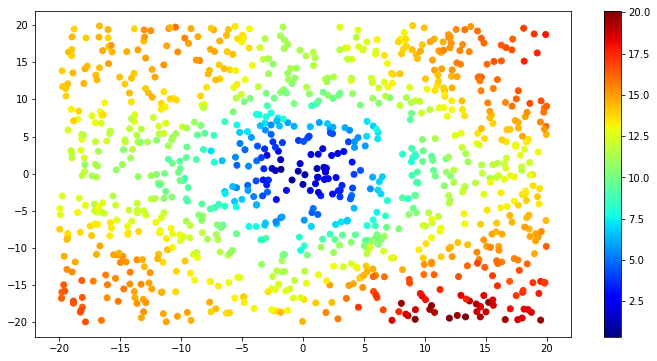

In [54]:
my_cmap = plt.cm.jet
my_cmap.set_under('white')

plt.figure(figsize=(12,6))

plt.scatter(mu[:, 0], mu[:, 1], c=y[:, 0], cmap=my_cmap)
plt.colorbar()
plt.show()

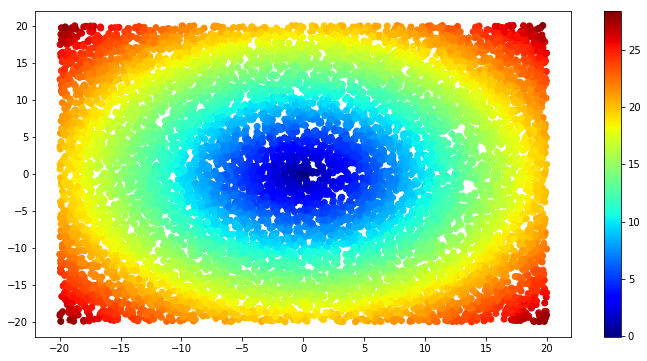

In [51]:
mu = dist.Uniform(-20, 20).sample([10000, 2])
x_r = y_sampler.x_dist.sample(torch.Size([len(mu), 1000]))
y_sampler.make_condition_sample({'mu': mu, 'X': x_r})

# y = torch.ones([10000, 1000]) * 0
# for index in range(10):
#     y += y_sampler.condition_sample()
# y /= 10
y = y_sampler.condition_sample()
y_mean = y.mean(dim=1)

plt.figure(figsize=(12,6))
plt.scatter(mu[:,0], mu[:, 1], c=y_mean, cmap=my_cmap)
plt.colorbar()